In [13]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [68]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [16]:
plt.rcParams['font.size'] = 12

In [28]:
data = pd.DataFrame({   
    'yield':[7, 13, 13, 11, 5, 6, 8, 11, 10, 11,
             11, 11, 11, 14, 8, 15, 10, 9, 13, 12,
             8, 15, 7, 11, 5, 11, 15, 10, 13, 9,
             8, 12, 13, 6, 8, 5, 13, 8, 5, 10,
             18, 9, 7, 12, 11, 5, 9, 10, 13, 13,
             7, 12, 8, 16, 10, 6, 12, 13, 10, 12, 
             9, 7, 12, 11, 8, 15, 13, 11, 9, 17,
             11, 10, 15, 19 ,11, 13, 12, 9, 10,10],

    'group':[0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,
             ]    
})

In [31]:
data.head()

,yield,group
0,7,0
1,13,0
2,13,0
3,11,0
4,5,0


In [44]:
y = data[data['group']==0]['yield'].values

In [45]:
print(y)

[ 7 13 13 11  5  6  8 11 10 11 11 11 11 14  8 15 10  9 13 12  8 15  7 11
  5 11 15 10 13  9  8 12 13  6  8  5 13  8  5 10 18  9  7 12 11  5  9 10
 13 13]


In [46]:
np.mean(y)

10.16

In [47]:
np.var(y)

9.1744

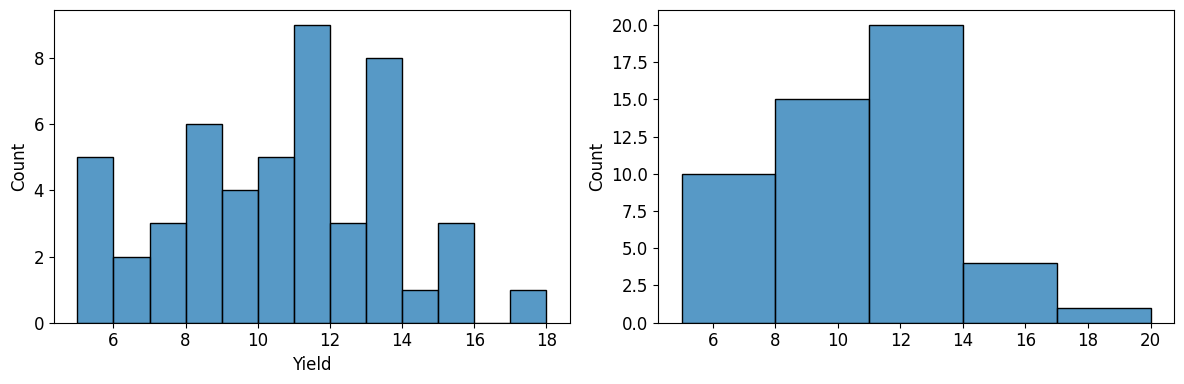

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(y, binwidth=1, ax=axes[0])
axes[0].set_xlabel('Yield')

sns.histplot(y, binwidth=3, ax=axes[1])
axes[0].set_xlabel('Yield')

plt.tight_layout()

In [55]:
def model(y=None, num_data=0):
    #パラメータの事前分布の定義
    mu = numpyro.sample('mu', dist.HalfNormal(10))
    
    #観測データに基づく尤度の定義
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

In [56]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

/tmp/ipykernel_14/714539352.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)


In [57]:
mcmc.run(jax.random.PRNGKey(0), y=y, num_data=len(y))

sample: 100% 3500/3500 [00:26<00:00, 133.01it/s, 3 steps of size 1.00e+00. acc. prob=0.93]
sample: 100% 3500/3500 [00:24<00:00, 142.32it/s, 3 steps of size 1.06e+00. acc. prob=0.93]
sample: 100% 3500/3500 [00:26<00:00, 132.93it/s, 1 steps of size 8.91e-01. acc. prob=0.94]
sample: 100% 3500/3500 [00:22<00:00, 154.53it/s, 3 steps of size 1.28e+00. acc. prob=0.91]


In [58]:
mcmc.samples = mcmc.get_samples()

In [59]:
idata = az.from_numpyro(mcmc)

In [60]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>]], dtype=object)

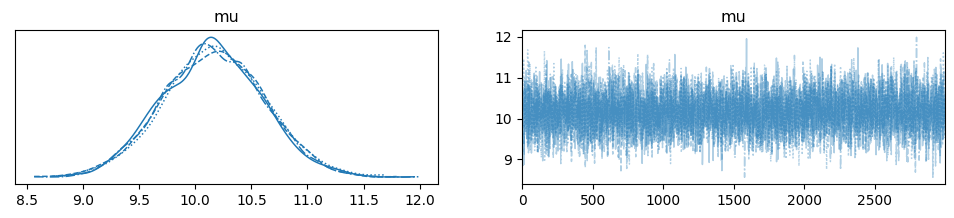

In [62]:
az.plot_trace(idata)

In [63]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.164,0.45,9.347,11.044,0.006,0.005,4918.0,5927.0,1.0


<AxesSubplot: title={'center': 'mu'}>

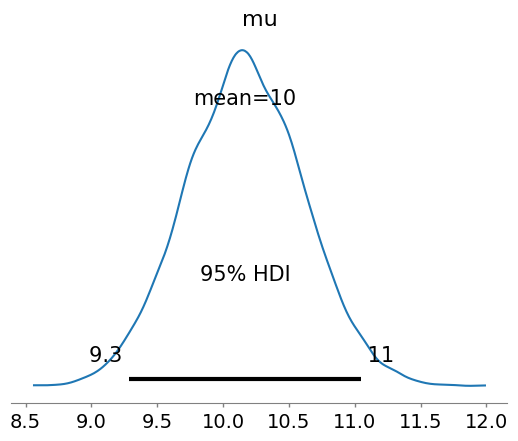

In [65]:
az.plot_posterior(idata, hdi_prob=0.95)

### 事後予測

In [69]:
predictive = numpyro.infer.Predictive(model, mcmc.samples)

In [70]:
ppc_samples = predictive(jax.random.PRNGKey(1), num_data=len(y))

In [81]:
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [73]:
ppc_samples['obs'].shape

(12000, 50)

In [74]:
ppc_mean = ppc_samples['obs'].mean(axis=1)
ppc_var = ppc_samples['obs'].var(axis=1)

In [75]:
ppc_mean.shape

(12000,)

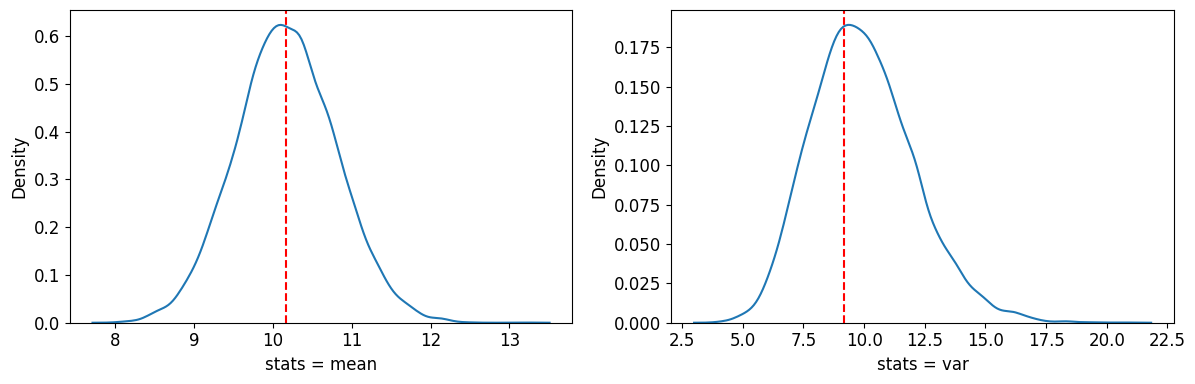

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.kdeplot(ppc_mean, ax=axes[0])
axes[0].axvline(y.mean(), color='r', linestyle='dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax=axes[1])
axes[1].axvline(y.var(), color='r', linestyle='dashed')
axes[1].set_xlabel('stats = var')

plt.tight_layout()

In [83]:
idata_ppc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<AxesSubplot: xlabel='obs / obs'>

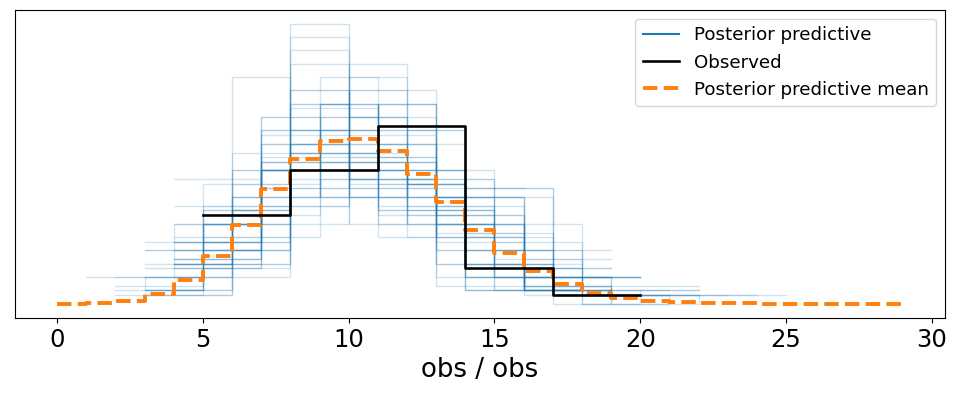

In [84]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12,4))

<AxesSubplot: xlabel='obs / obs'>

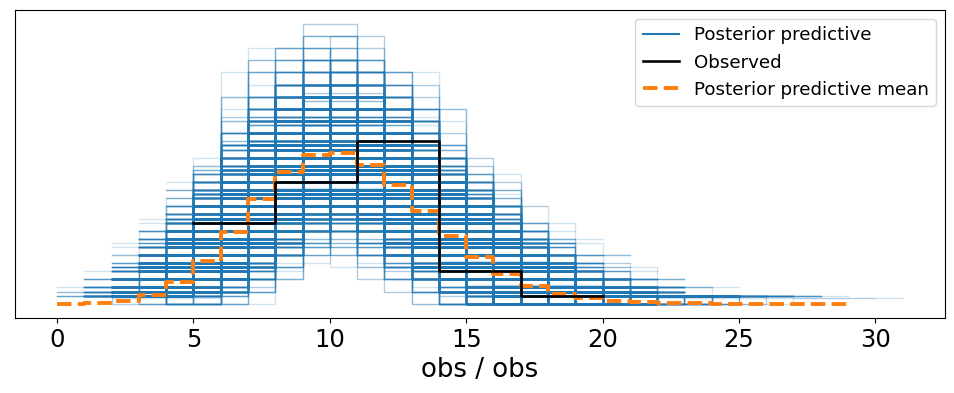

In [85]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12,4))

観測データのヒストグラムと予測分布のヒストグラム重なっているため悪くない